In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')
import pdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [3]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [4]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    df = calculateEMA(df,DAYS,newColumns)
    df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [5]:
def exp_chronos(df, target_col='open', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    # 2. Selecionar a série alvo
    y_train = df_train[target_col].values
    y_valid = df_valid[target_col].values
    y_test  = df_test[target_col].values

    # 3. Preparar entrada para Chronos
    serie_torch = torch.tensor(np.concatenate([y_train, y_valid]), dtype=torch.float32)
    
    pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="auto")
    quantiles, mean = pipeline.predict_quantiles(
        context=serie_torch,
        prediction_length=prediction_length,
        quantile_levels=[0.1, 0.5, 0.9]
    )

    #4.Resultados
    y_pred_mean = mean[0].numpy()
    y_test_orig = y_test[-prediction_length:]
    q10 = quantiles[0, :, 0].numpy()
    q90 = quantiles[0, :, 2].numpy()
    uncertainty = q90 - q10

    return [y_test_orig, y_pred_mean, uncertainty]

In [6]:
def runPrediction(fundo):
    df = create_df(fundo)

    orig_high, pred_high, uncertainty_high = exp_chronos(df, prediction_length=40, target_col='high')
    orig_low, pred_low, uncertainty_low = exp_chronos(df, prediction_length=40, target_col='high')

    return [orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low]
    

In [ ]:
fundos = ['ABEV3', 'BBDC4', 'EGIE3', 'ITUB4', 'JBSS3', 'VALE3', 'PETR4']
for name in fundos:
    orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low = runPrediction(name)
    result_prediction = pd.DataFrame()
    result_prediction['date'] = getPeriod(df, TEST_BEGIN, TEST_END)['date']
    result_prediction['high_pred'] = pred_high
    result_prediction['low_pred'] = pred_low
    result_prediction['uncertainty_high'] = uncertainty_high
    result_prediction['uncertainty_low'] = uncertainty_low
    result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
    #result_prediction['uncertainty_valid_mean'] = (f[:,0] + f[:,1]) / 2
    result_prediction['high'] = orig_high
    result_prediction['low'] = orig_low
    result_prediction.to_pickle(f'../Data/{name}_Pred_No_Finetuning.pkl')


In [8]:
pred_PETR4 = pd.read_pickle('../Data/PETR4_Pred_No_Finetuning.pkl')
pred_PETR4 = pred_PETR4.reset_index()
pred_PETR4

,index,date,high_pred,low_pred,uncertainty_high,uncertainty_low,uncertainty_mean,high,low
0,1299,2021.04.06,23.512608,23.379816,0.725937,0.725916,0.725926,23.58,23.58
1,1300,2021.04.07,23.494900,23.238178,0.761326,1.451853,1.106589,23.55,23.55
2,1301,2021.04.08,23.574574,23.362112,1.274790,1.859076,1.566933,23.26,23.26
3,1302,2021.04.09,23.698517,23.379818,1.416420,2.230864,1.823642,23.01,23.01
4,1303,2021.04.12,23.751637,23.548019,1.593485,1.947601,1.770543,23.58,23.58
5,1304,2021.04.13,23.955242,23.530317,1.682013,2.089231,1.885622,23.33,23.33
6,1305,2021.04.14,24.017214,23.618839,1.682011,2.549561,2.115786,23.78,23.78
7,1306,2021.04.15,23.964096,23.716219,1.841347,2.726622,2.283984,23.83,23.83
8,1307,2021.04.16,24.105740,23.671955,2.071527,3.116138,2.593833,23.24,23.24
9,1308,2021.04.19,24.203119,23.875568,2.372519,2.691210,2.531864,24.89,24.89


Você está dizendo:

Me mostre, para os próximos 5 dias:

O valor mais pessimista (quantil 0.1)

O valor mais provável (mediana, quantil 0.5)

O valor mais otimista (quantil 0.9)

📊 Exemplo numérico (dia 1)
Quantil	Valor	Interpretação
0.1	    23.1	10% das previsões ficam abaixo de 23.1 → valor conservador
0.5	    24.0	Previsão mais provável (mediana)
0.9	    25.4	90% das previsões ficam abaixo de 25.4 → valor otimista


**Fine tuning?**

In [11]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [12]:
print(df.head(10))

         date  open  high   low  close  EMA_open  EMA_high   EMA_low  \
0  2016.01.04  5.96  6.38  5.94   6.23  5.960000  6.380000  5.940000   
1  2016.01.05  6.28  6.35  6.00   6.06  6.280000  6.350000  6.000000   
2  2016.01.06  5.92  5.93  5.80   5.80  5.920000  5.930000  5.800000   
3  2016.01.07  5.61  5.83  5.51   5.68  5.610000  5.830000  5.510000   
4  2016.01.08  5.79  5.85  5.56   5.69  6.053333  6.220000  5.913333   
5  2016.01.11  5.69  5.71  5.49   5.52  5.932222  6.050000  5.772222   
6  2016.01.12  5.55  5.55  5.00   5.02  5.804815  5.883333  5.514815   
7  2016.01.13  5.17  5.21  4.76   4.78  5.593210  5.658889  5.263210   
8  2016.01.14  4.82  5.16  4.65   5.16  5.335473  5.492593  5.058807   
9  2016.01.15  4.85  4.93  4.68   4.69  5.173649  5.305062  4.932538   

   EMA_close   UB_open  ...  d-3_low  d-3_close  d-4_open  d-4_high  d-4_low  \
0   6.230000       NaN  ...      NaN        NaN       NaN       NaN      NaN   
1   6.060000       NaN  ...      NaN        NaN

In [13]:
def getTrainDf(df_train):
    df_train = df_train.copy()
    df_train['item_id'] = 'ASSET'  # obrigatório mesmo com 1 série
    df_train = df_train[['item_id', 'date', 'open', 'high', 'low', 'close']]
    df_train.columns = ['item_id', 'timestamp', 'open', 'high', 'low', 'close']

    # Transformar em TimeSeriesDataFrame
    ts_df = TimeSeriesDataFrame(df_train)
    return ts_df

In [14]:
def getTestDf(df):
    df_test = df.copy()
    df_test['item_id'] = 'ASSET'
    df_test = df_test[['item_id', 'date', 'high', 'low', 'close']]
    df_test.columns = ['item_id', 'timestamp', 'high', 'low', 'close']

    return TimeSeriesDataFrame(df_test)


In [15]:
def fixHoliday(df):
    df_ts = df.reset_index()
    nova_linha = {
        'item_id': 'ASSET',
        'timestamp': pd.Timestamp('2021-04-21'),
        'high': 24.59,
        'low': 23.76,
        'close': 23.82
    }
    df_ts = pd.concat([df_ts.iloc[:11], pd.DataFrame([nova_linha]), df_ts.iloc[11:]], ignore_index=True)
    return TimeSeriesDataFrame(df_ts)

In [16]:
def generatePredictor(df, target_col='open', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):
    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)

    train_df = pd.concat([df_train, df_valid])

    # 3. Preparar entrada para Chronos
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target=target_col,
        known_covariates_names=["high", "low", "close"],
        freq="B"
    ).fit(
        getTrainDf(train_df),
        hyperparameters={
            "Chronos": [
                {
                    "model_path": "bolt_small",
                    "ag_args": {"name_suffix": "ZeroShot"},
                },
                {
                    "model_path": "bolt_small",
                    "covariate_regressor": "CAT",
                    "target_scaler": "standard",
                    "ag_args": {"name_suffix": "WithRegressor"},
                },
            ],
        },
        enable_ensemble=False,
        time_limit=None,
    )

    return predictor
           

In [18]:
predictor = generatePredictor(df, prediction_length=41)

Beginning AutoGluon training...


AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250607_205711'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       17.40 GB / 31.94 GB (54.5%)
Disk Space Avail:   226.29 GB / 446.38 GB (50.7%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['high

In [19]:
def exp_chronos_with_finetuning(df, target_col='open', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01'):
    
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    y_test  = df_test[target_col].values

    inputDf = getTrainDf(pd.concat([df_train, df_valid]))
    covariates_df = getTestDf(df_test)
    covariates_df = fixHoliday(covariates_df)    
  
    forecast = predictor.predict(inputDf, known_covariates=covariates_df)

    #4.Resultados
    y_pred_mean = forecast['mean']
    y_test_orig = y_test[-40:]
    q10 = forecast['0.1']
    q90 = forecast['0.9']
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: ChronosWithRegressor[bolt_small]


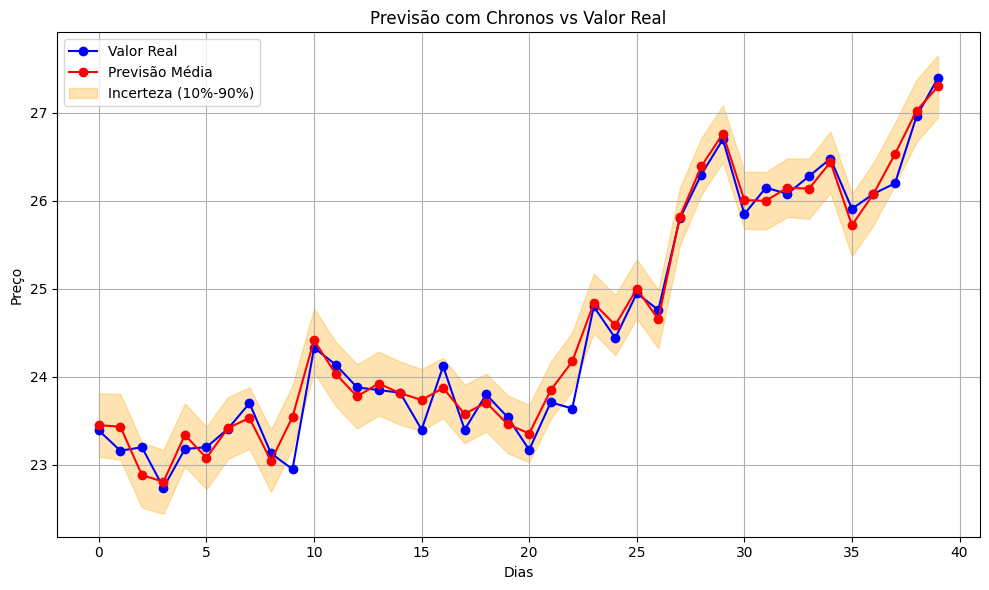

In [22]:
y_test_orig, y_pred_mean, uncertainty = exp_chronos_with_finetuning(df)

y_pred_mean = y_pred_mean.drop(y_pred_mean.index[11])
uncertainty = uncertainty.drop(uncertainty.index[11])

# Criar eixo de tempo
dias = np.arange(len(y_test_orig))

# Calcular faixa de incerteza (intervalo 90% - 10%)
inferior = y_pred_mean - (uncertainty / 2)
superior = y_pred_mean + (uncertainty / 2)

plt.figure(figsize=(10, 6))

# Linha real (azul)
plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

# Linha prevista (laranja)
plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

# Faixa de incerteza (sombreada)
plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

# Rótulos e legendas
plt.title('Previsão com Chronos vs Valor Real')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
